In [1]:
# Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import levy_stable
from scipy.optimize import least_squares
from scipy.optimize import minimize
import yfinance as yf #https://pypi.org/project/yfinance/
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [2]:
# Functions and classes

class return_functions:
    
     def __init__(self,stock_prices):
        self.stock_prices = stock_prices

     def get_index_array(self):
        '''
        This function outputs array that indexes only 
        to the not nans in the stock prices. MAY NOT BE NECESSARY
        '''
        ind_not_nan=np.where(np.isnan(self.stock_prices)==False)[0]
        return ind_not_nan
    
     def log_returns(self):
        '''
        Finds log returns of array of stock prices.
        See https://gregorygundersen.com/blog/2022/02/06/log-returns/
        Input: stock prices object
        Output: float array of log returns
        '''
        ind_not_nan = self.get_index_array()
        stock_prices_f=np.asarray(self.stock_prices[ind_not_nan],float) 
        return np.log(stock_prices_f[1:]/stock_prices_f[:-1])

     def get_kernel_density(self):
        '''Outputs x and y axis of kernel density of log-returns. NOT USED.'''
        log_returns_s=self.log_returns()
        density = stats.gaussian_kde(log_returns_s)
        x = np.linspace(log_returns_s.min(), log_returns_s.max())
        y = density.evaluate(x)
        return x, y

     def normal_fit(self):
         '''Outputs x and y axis of normal pdf fit of log-returns. NOT USED.'''
         log_returns_s=self.log_returns()
         mu,sigma=np.mean(log_returns_s), np.std(log_returns_s)
         x = np.linspace(log_returns_s.min(), log_returns_s.max())
         y = norm.pdf(x,mu,sigma)
         return x, y

     def abs_returns_empirical_tail(self):
         '''Gets the empirical tail of the absolute value of log-returns. NOT USED.'''
         log_returns_s = self.log_returns()
         abs_log_returns = np.abs(log_returns_s)
         x, y = empirical_fns(abs_log_returns).empirical_tail()
         return x, y

class empirical_fns:

    def __init__(self,data):
        self.data = data
        
    def empirical_cdf(self):
        """
        From ChatGPT with minor adjustments.
        Calculate the empirical cumulative distribution function (ECDF) of the given data.
    
        Inputs:
        data (array-like): Input data array.
    
        Returns:
        x (array): Sorted unique values of the input data.
        y (array): Empirical cumulative probabilities corresponding to the sorted unique values.
        """
        # Sort the data
        sorted_data = np.sort(self.data)
        
        # Calculate the empirical cumulative probabilities, note y-values start at 0 so tail values (1-y) start at 1
        n = len(sorted_data)
        y = np.arange(0, n ) / n
        
        return sorted_data, y

    def empirical_tail(self):
        '''
        Calculate the empirical tail function (1-ECDF) of the given data.
        
        Inputs: data (array-like): Input data array.
    
        Returns:
        x (array): Sorted unique values of the input data.
        y (array): Empirical tail probabilities corresponding to the sorted unique values.
        '''
        x, y = self.empirical_cdf() 

        return x, 1-y

class tail_fns:
      
    def k_gen_exp(x,k):
        '''
        Inputs variable x and parameter k.
        Outputs the k-generalised exponential function.
        '''
        return (np.sqrt(1+k**2*x**2)+k*x)**(1/k)
    
    def k_gen_dist_tail(x,k,a,b):
        '''
        Inputs variable x and parameters k, a, b.
        Outputs the tail of the k-generalised distribution
        '''
        x1= -b*x**a
        return tail_fns.k_gen_exp(x1,k)
    
    def exp_tail(x,l): # NOT USED.
        '''
        Inputs variable x and parameter l.
        Outputs the tail of the exponential distribution
        '''
        return np.exp(-x/l)

    def rmsd(y_act,y_pred): # NOT USED.
        '''
        Inputs actual empirical tail y-values and y-values tail prediction.
        Outputs root mean square deviation https://en.wikipedia.org/wiki/Root-mean-square_deviation
        '''
        n=len(y_act)
        return np.sum(np.sqrt(1/n*(y_act-y_pred)**2))

    def ks_stat(y,y_pred):
        '''
        Inputs:
        y - empirical tail of data
        y_pred - predicted tail value for y
        Output: Kolmogorov-Smirnoff statistic
        '''
        return np.max(np.abs(y-y_pred))

    def tail_params_errors(stock_names):
        '''
        Inputs array of stock names.
        Outputs array of parameter fits and 
        errors of normal, Levy-stable and k-generalised distribution fits to the stock tails tails
        '''
        params = []
        errors_norm = []
        errors_levy_stable = []
        errors_k_gen = []
        for i in range(len(stock_names)):
            data = yf.download(stock_names[i], period="max")
            param, e_norm, e_levy_stable, e_k_gen = tail_param_error(data)
            params.append(param)
            errors_norm.append(e_norm)
            errors_levy_stable.append(e_levy_stable)
            errors_k_gen.append(e_k_gen)
            print(i)
        return params,errors_norm, errors_levy_stable, errors_k_gen

    def get_characteristics_errors(errors):
        ''' 
        Inputs array of the errors.
        Outputs the min, max, mean and variance of the errors.
        '''
        errors = np.asarray(errors,float)
        return errors.min(), errors.max(), errors.mean(), errors.var()

    def where_greater(e1,e2):
        '''
        Input arrays of errors e1, e2 of same length.
        Output number of times element i in e1 greater than element i in e2
        '''
        c=0
        for i in range(len(e1)):
            if e1[i]>e2[i]:
                c+=1
        return c


class fit_tail_ls: # NOT USED.

    def least_square_residuals(params,f,x,y):
        '''
        Inputs parameters (params), function (f) and variables x, y
        Performs least squares to fit the parameters of the function f(x,params) to y
        '''
        return y-f(x,*params)
    
    def get_least_squares_fit(params0, bds,f,x,y):
        '''
        Inputs initial parameters for fitting (params0), bounds of parameters to fit (bds), function (f) and variables x, y
        Performs least squares to fit parameters of the function. 
        NOTE does not work as well as maximising the MLE numerically due to error bias..
        '''
        sol=least_squares(fit_tail_ls.least_square_residuals, params0, args=((f, x, y)),bounds=bds)
        return sol.x

class k_gen_fitting:
    
    def k_gen_dens(x,k,a,b):
        ''' 
        Inputs variable x and parameters k, a, b
        Outputs density of k-generalised distribution.
        '''
        s1=a*b*x**(a-1)
        s2=np.sqrt(1+b**2*k**2*x**(2*a))
        s3=tail_fns.k_gen_dist_tail(x,k,a,b)
        return s1/s2*s3
    
    def k_gen_log_like(params,x):
        '''
        Inputs parameters (params) and variable x.
        Outputs negative of log-likelihood of k-generalised distribution.
        '''
        return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))

    def k_gen_like_fit(params,bds,x):
        ''' 
        Inputs parameters (params), bounds on parameters (bds) and variable x
        Outputs numerical minimum of negative likelihood of k-generalised distribution.
        Note this is equivalent to maximising the log-likelihood.
        '''
        sol=minimize(k_gen_fitting.k_gen_log_like, params, args=(x),bounds=bds)
        return sol.x

    def log_k(x,k):
        '''
        Inputs variable x and parameter k.
        Outputs k-logarithm
        '''
        return (x**k-x**(-k))/(2*k)
    
    def k_gen_tail_sample(y,p,k,a,b):
        '''
        Inputs variable y-values of tail, parameters p (proportion parameter), k, a, b (k-gen. parameters)
        Outputs k-generalised sample.
        '''
        return (-1/b*k_gen_fitting.log_k(y/p,k))**(1/a)

class plotting:
    
    def __init__(self,ax,myxlabel,myylabel,font_sizes,leg):
        self.ax = ax
        self.myxlabel = myxlabel
        self.myylabel = myylabel
        self.font_sizes = font_sizes
        self.leg = leg

    def add_labels(self):
        '''
        Adds labels, grid and optional legend to plot.
        Inputs: 
        ax - plotting object
        myxlabel - xlabel string
        myylabel - ylabel string
        font_sizes - array of size 5 of fontsizes for xlabel string, 
        ylabel string, xticks, yticks and legend
        leg - if 1 put in the legend, otherwise do not
        Output: ax - plotting object with the added inputs
        '''
        self.ax.set_xlabel(self.myxlabel,fontsize=self.font_sizes[0])
        self.ax.set_ylabel(self.myylabel,fontsize=self.font_sizes[1])
        self.ax.grid(color='grey', linestyle='--', linewidth=0.5)
        self.ax.tick_params(axis='x', labelsize=self.font_sizes[2])
        self.ax.tick_params(axis='y', labelsize=self.font_sizes[3])
        if(self.leg==1):
            self.ax.legend(fontsize=self.font_sizes[4])
        return self.ax

def get_stock_prices_dates(data):
    '''
    Inputs: data - dataframe of stock
    Outputs: dates of stock, time interval of stocks in years, stock prices
    '''
    # Get dates which is the index column of the data frame
    data['Date']=data.index
    dates=data['Date']
    
    # Get number of years of historic stock data
    start_date = dates.iloc[0]
    end_date = dates.iloc[-1]
    difference_in_years = relativedelta(end_date, start_date).years
    
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)

    return dates, difference_in_years, stock_prices

def plot_stock_info(data,stock):
    '''
    Inputs: data - dataframe of stock, stock - stock code.
    Outputs: plot the stock price, log returns and fits of tails of log-returns with k-generalised distribution and normal.
    '''

    dates, difference_in_years, stock_prices =  get_stock_prices_dates(data)
    stock_type = 'Close'
    
    returns = return_functions(stock_prices) # Enter stock-prices to returns class
    log_returns = returns.log_returns() # Get log-returns
    log_returns_neg = log_returns[log_returns<0] # Gets negative log-returns
    log_returns_pos = log_returns[log_returns>0] # Gets positive log-returns
    
    q=len(log_returns_neg)/len(log_returns) # Proportion of log-returns that are negative
    
    x,y = empirical_fns(log_returns_neg).empirical_cdf() # Get empirical cdf of negative log-returns
    x1,y1 = empirical_fns(log_returns_pos).empirical_tail() # Get empirical tail of positive log-returns
    
    params0=[0.5,1,1] # Parameter initialisation for MLE k-gen
    bds = [(10**-1,1),(10**-3,np.inf),(10**-3,np.inf)] # Parameter bounds for MLE k-gen
    
    params_pred=k_gen_fitting.k_gen_like_fit(params0,bds,-log_returns_neg) # MLE k-gen parameter fit to tail of negative log_returns
    params_pred1=k_gen_fitting.k_gen_like_fit(params0,bds,log_returns_pos) # MLE k-gen parameter fit to tail of  positive log_returns
    k_gen_pred = q*tail_fns.k_gen_dist_tail(-x[1:],*params_pred) # MLE k-gen prediction for tail of negative log_returns
    k_gen_pred1 = (1-q)*tail_fns.k_gen_dist_tail(x1,*params_pred1) # MLE k-gen prediction for tail of positive log_returns

    params_pred_normal=norm.fit(log_returns) # MLE normal parameter fit to log-returns
    norm_pred=norm.cdf(x[1:], *params_pred_normal) # Normal fit tail of negative log_returns
    norm_pred1=norm.sf(x1, *params_pred_normal) # Normal fit tail of positive log_returns

    levy_stable.parameterization = 'S0' # Levy-stable set parameter - default S1
    params_pred_levy_stable = levy_stable._fitstart(log_returns) # Levy-stable MLE fit
    levy_stable_pred=levy_stable.sf(-x[1:], *params_pred_levy_stable) # Levy-stable fit prediction tail of negative log_returns
    levy_stable_pred1=levy_stable.sf(x1, *params_pred_levy_stable) # Levy-stable fit prediction tail of positive log_returns

    # Plot historical daily (closed) stock price, log returns and k-generalised and normal fits to tails of log returns ##############
    fig, ax = plt.subplots(2,2,figsize=(10,5)) 

    if difference_in_years <= 10:
        ax[0,0].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
        ax[0,1].xaxis.set_major_locator(mdates.YearLocator(1)) # Sorts issue with repeating years over small range
    
    ax[0,0].plot(dates,stock_prices,label=stock+' '+stock_type)
    # ax[0,0].set_yscale('log')
    font_sizes = [10,10,10,10,12]
    leg=1
    labels=['Date','Stock price',font_sizes,leg]
    plotting(ax[0,0],*labels).add_labels()
    ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis
    
    ax[0,1].plot(dates[1:],log_returns,label=stock)
    leg=0
    labels=['Date',r'Returns ($R$)',font_sizes,leg]
    plotting(ax[0,1],*labels).add_labels()
    ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Set dates to year only for x-axis 
    
    ax[1,0].plot(x[1:],q*y[1:],'o')
    ax[1,0].plot(x[1:], k_gen_pred, label=r'$\kappa$-gen.',linestyle = '-')
    ax[1,0].plot(x[1:],levy_stable_pred,label='HT stable',linestyle = '--')
    ax[1,0].plot(x[1:],norm_pred,label='Normal',linestyle = '-.')
    ax[1,0].set_yscale('log')
    # font_sizes = [10,10,10,10,10]
    leg=1
    labels=[r'$r$',r'$\mathbb{P}(R<r)$',font_sizes,leg]
    plotting(ax[1,0],*labels).add_labels()
    ax[1,0].set_ylim([0.5*(q*y[1:]).min(), 1.5*(q*y[1:]).max()])
    
    ax[1,1].plot(x1, (1-q)*y1,'o')
    ax[1,1].plot(x1, k_gen_pred1, label=r'$\kappa$-gen.',linestyle = '-')
    ax[1,1].plot(x1,levy_stable_pred1,label='HT stable',linestyle = '--')
    ax[1,1].plot(x1,norm_pred1,label='Normal',linestyle = '-.')
    ax[1,1].set_yscale('log')
    # font_sizes = [10,10,10,10,10]
    leg=1
    labels=[r'$r$',r'$\mathbb{P}(R>r)$',font_sizes,leg]
    plotting(ax[1,1],*labels).add_labels()
    ax[1,1].set_ylim([0.5*((1-q)*y1).min(), 1.5*((1-q)*y1).max()])
    
    plt.tight_layout()
    ##########################################################################

def tail_param_error(data):
    '''
    Inputs dataframe for yahoo stock.
    Outputs parameter fits and Kolmogorov-Smirnoff (KS) error statistics of normal, Levy-stable
    and k-generalised MLE fits to negative and positve tails of log-returns
    '''
    
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)
    
    returns = return_functions(stock_prices) # Enter stock-prices to returns class
    log_returns = returns.log_returns() # Get log-returns
    log_returns_neg = log_returns[log_returns<0] # Gets negative log-returns
    log_returns_pos = log_returns[log_returns>0] # Gets positive log-returns
    
    q=len(log_returns_neg)/len(log_returns) # Proportion of log-returns that are negative
    
    x,y = empirical_fns(log_returns_neg).empirical_cdf() # Get empirical cdf of negative log-returns
    x1,y1 = empirical_fns(log_returns_pos).empirical_tail() # Get empirical tail of positive log-returns
    
    # MLE fit with normal
    params_pred_normal = norm.fit(log_returns)
    norm_pred=norm.sf(-x[1:], *params_pred_normal) # Normal fit prediction tail of negative log_returns
    norm_pred1=norm.sf(x1, *params_pred_normal) # Normal fit prediction tail of positive log_returns

    # MLE fit with Levy stable
    levy_stable.parameterization = 'S0' # Levy-stable set parameter - default S1 
    params_pred_levy_stable = levy_stable._fitstart(log_returns) # Levy-stable MLE fit
    levy_stable_pred=levy_stable.sf(-x[1:], *params_pred_levy_stable) # Levy-stable fit prediction tail of negative log_returns
    levy_stable_pred1=levy_stable.sf(x1, *params_pred_levy_stable) # Levy-stable fit prediction tail of positive log_returns

    # MLE fit with k-gen
    params0=[0.5,1,1] # Parameter initialisation for MLE
    bds = [(10**-1,1),(10**-3,np.inf),(10**-3,np.inf)] # Parameter bounds for MLE
    
    params_pred_k_gen=k_gen_fitting.k_gen_like_fit(params0,bds,-log_returns_neg) # MLE k-gen parameter fit to tail of negative log_returns
    params_pred_k_gen1=k_gen_fitting.k_gen_like_fit(params0,bds,log_returns_pos) # MLE k-gen parameter fit to tail of  positive log_returns
    k_gen_pred = q*tail_fns.k_gen_dist_tail(-x[1:],*params_pred_k_gen) # MLE k-gen prediction for tail of negative log_returns
    k_gen_pred1 = (1-q)*tail_fns.k_gen_dist_tail(x1,*params_pred_k_gen1) # MLE k-gen prediction for tail of positive log_returns

    param = [params_pred_normal,params_pred_levy_stable,params_pred_k_gen,params_pred_k_gen1]
    
    y_act = np.concatenate((q*y[1:],(1-q)*y1)) # Concatenate empirical tails for negative and positive log-returns
    norm_y_pred = np.concatenate((norm_pred,norm_pred1)) # Concatenate normal tail fits for negative and positive log-returns
    levy_stable_y_pred = np.concatenate((levy_stable_pred,levy_stable_pred1)) # Concatenate Levy stable tail fits for negative and positive log-returns
    k_gen_y_pred = np.concatenate((k_gen_pred, k_gen_pred1)) # Concatenate k-gen. tail fits for negative and positive log-returns

    return param, tail_fns.ks_stat(y_act,norm_y_pred), tail_fns.ks_stat(y_act,levy_stable_y_pred),tail_fns.ks_stat(y_act,k_gen_y_pred)

def p_values_k_gen_fits(N,data):
    '''
    Get simulated p-values for k-generalised  fits to negative and positive log-returns tails 
    Inputs:
    N - number of times to simulate to get p-values
    data - stock data
    Outputs:
    p_value_neg - p-value for negative tail
    p_value_pos - p-value for positive tail
    '''
    
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)
    
    returns = return_functions(stock_prices) # Enter stock-prices to returns class
    log_returns = returns.log_returns() # Get log-returns
    log_returns_neg = log_returns[log_returns<0] # Gets negative log-returns
    log_returns_pos = log_returns[log_returns>0] # Gets negative log-returns
    
    q=len(log_returns_neg)/len(log_returns) # Proportion of log-returns that are negative
    
    x,y = empirical_fns(log_returns_neg).empirical_cdf() # Get empirical cdf of negative log-returns
    x1,y1 = empirical_fns(log_returns_pos).empirical_tail() # Get empirical tail of positive log-returns
    
    params0=[0.5,1,1] # Parameter initialisation for MLE
    bds = [(10**-1,1),(10**-3,np.inf),(10**-3,np.inf)] # Parameter bounds for MLE
    
    params_pred=k_gen_fitting.k_gen_like_fit(params0,bds,-log_returns_neg) # MLE k-gen parameter fit to tail of negative log-returns
    params_pred1=k_gen_fitting.k_gen_like_fit(params0,bds,log_returns_pos) # MLE k-gen parameter fit to tail of  positive log-returns
    k_gen_pred = q*tail_fns.k_gen_dist_tail(-x[1:],*params_pred) # MLE k-gen prediction for tail of negative log-returns
    k_gen_pred1 = (1-q)*tail_fns.k_gen_dist_tail(x1,*params_pred1) # MLE k-gen prediction for tail of positive log-returns
    
    e_neg = tail_fns.ks_stat(q*y[1:],k_gen_pred) # Kolmogorov-Smirnoff statistic for tail fit to negative log-returns
    e_pos = tail_fns.ks_stat((1-q)*y1,k_gen_pred1) # Kolmogorov-Smirnoff statistic for tail fit to positive log-returns

    n=len(x[1:]) # Sample size for negative log-returns
    n1=len(x) # Sample size for positive log-returns
    es, e1s = [], [] # Initialise array to hold KS statistics

    # Simulate N samples of k-generalised distribution with above fitted parameters and then fit to get KS-statistics
    for i in range(N):
        y_samp = uniform.rvs(loc=0, scale=q, size=n, random_state=i) # Generate uniform y-tail values for negative log-returns with seed
        y_samp1 = uniform.rvs(loc=0, scale=(1-q), size=n1, random_state=i) # Generate uniform y-tail values for positive log-returns with seed
        
        s = -k_gen_fitting.k_gen_tail_sample(y_samp,q,*params_pred) # Generate k-generalised sample for negative log-returns
        s1 = k_gen_fitting.k_gen_tail_sample(y_samp1,(1-q),*params_pred1) # Generate k-generalised sample for positive log-returns
        
        x,y = empirical_fns(s).empirical_cdf() # Get empirical cdf of negative log-returns
        x1,y1 = empirical_fns(s1).empirical_tail()  # Get empirical tail of positive log-returns
        
        params0=[0.5,1,1] # Parameter initialisation for MLE
        bds = [(10**-1,1),(10**-3,np.inf),(10**-3,np.inf)] # Parameter bounds for MLE
        
        params_pred2=k_gen_fitting.k_gen_like_fit(params0,bds,-s) # MLE k-gen parameter fit to tail of negative log_returns
        params_pred3=k_gen_fitting.k_gen_like_fit(params0,bds,s1) # MLE k-gen parameter fit to tail of  positive log_returns
        k_gen_pred = q*tail_fns.k_gen_dist_tail(-x,*params_pred2) # MLE k-gen prediction for tail of negative log_returns
        k_gen_pred1 = (1-q)*tail_fns.k_gen_dist_tail(x1,*params_pred3) # MLE k-gen prediction for tail of positive log_returns
        
        e = tail_fns.ks_stat(q*y,k_gen_pred) # KS statistic negative log-returns
        e1 = tail_fns.ks_stat((1-q)*y1,k_gen_pred1) # KS statistic positive log-returns
        # Append to arrays
        es.append(e)
        e1s.append(e1)
    # Get p-values
    # p-value defined as proportion of simulated KS-statistic greater than KS-statistic for data
    # High p-value more likely data from k-gen distribution
    p_value_neg = len(np.where(es > e_neg)[0])/len(es)
    p_value_pos = len(np.where(e1s > e_pos)[0])/len(e1s)
    return p_value_neg, p_value_pos

def generate_stock_values(data):
    '''
    Inputs dataframe for yahoo stock.
    Outputs generated stock values using k-gen. fits from first value of stock.
    '''
    # Stock prices as float
    stock_type = 'Close'
    stock_prices = np.asarray(data[stock_type],float)
    
    returns = return_functions(stock_prices) # Enter stock-prices to returns class
    log_returns = returns.log_returns() # Get log-returns
    log_returns_neg = log_returns[log_returns<0] # Gets negative log-returns
    log_returns_pos = log_returns[log_returns>0] # Gets positive log-returns
    
    q=len(log_returns_neg)/len(log_returns) # Proportion of log-returns that are negative
    
    x,y = empirical_fns(log_returns_neg).empirical_cdf() # Get empirical cdf of negative log-returns
    x1,y1 = empirical_fns(log_returns_pos).empirical_tail() # Get empirical tail of positive log-returns
    
    params0=[0.5,1,1] # Parameter initialisation for MLE k-gen
    bds = [(10**-1,1),(10**-3,np.inf),(10**-3,np.inf)] # Parameter bounds for MLE k-gen
    
    params_pred=k_gen_fitting.k_gen_like_fit(params0,bds,-log_returns_neg) # MLE k-gen parameter fit to tail of negative log_returns
    params_pred1=k_gen_fitting.k_gen_like_fit(params0,bds,log_returns_pos) # MLE k-gen parameter fit to tail of  positive log_returns
    k_gen_pred = q*tail_fns.k_gen_dist_tail(-x[1:],*params_pred) # MLE k-gen prediction for tail of negative log_returns
    k_gen_pred1 = (1-q)*tail_fns.k_gen_dist_tail(x1,*params_pred1) # MLE k-gen prediction for tail of positive log_returns

    ## Generate stock prices using k-gen distribution
    n = len(stock_prices)-1 # Set length of stock price to be generated (first value taken as actual stock value)
    p = uniform.rvs(size = n) 
    
    s = stock_prices[0]
    stock_gen = [s] # Array to hold generated stock values
    
    for i in range(n):
        if p[i]<q: # Generate a stock value with negative returns using k-gen
            y_samp = uniform.rvs(loc=0, scale=q)
            s = s*np.exp(-k_gen_fitting.k_gen_tail_sample(y_samp,q,*params_pred)) # Generate k-generalised sample for negative log-returns
        else:# Generate a stock value with negative returns using k-gen
            y_samp1 = uniform.rvs(loc=0, scale=1-q)
            s = s*np.exp(k_gen_fitting.k_gen_tail_sample(y_samp1,(1-q),*params_pred1)) # Generate k-generalised sample for positive log-returns
        stock_gen.append(s)
        
    return stock_gen
    

# Data

See https://pypi.org/project/yfinance/ for details on yfinance Python package that downloads historical stock data from Yahoo.

See https://aroussi.com/post/python-yahoo-finance for further details of use.

In [3]:
# Download the Yahoo stock data using yfinance

stock = '^NYA'
# stock = '^IXIC'
# stock = '^FTSE'
# stock = 'AAPL'
# stock = 'BTC-GBP'
# stock = 'ABNB'

data = yf.download(stock, period="max") # Dataframe for stock. Note sometimes a stock fails to download!

[*********************100%%**********************]  1 of 1 completed


In [4]:
currency = yf.Ticker(stock).info['currency']
print(currency)

USD


In [5]:
# Preview first 5 rows
print(data.head())

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
1965-12-31  528.690002  528.690002  528.690002  528.690002  528.690002       0
1966-01-03  527.210022  527.210022  527.210022  527.210022  527.210022       0
1966-01-04  527.840027  527.840027  527.840027  527.840027  527.840027       0
1966-01-05  531.119995  531.119995  531.119995  531.119995  531.119995       0
1966-01-06  532.070007  532.070007  532.070007  532.070007  532.070007       0


CPU times: user 9.82 s, sys: 1.6 s, total: 11.4 s
Wall time: 9.64 s


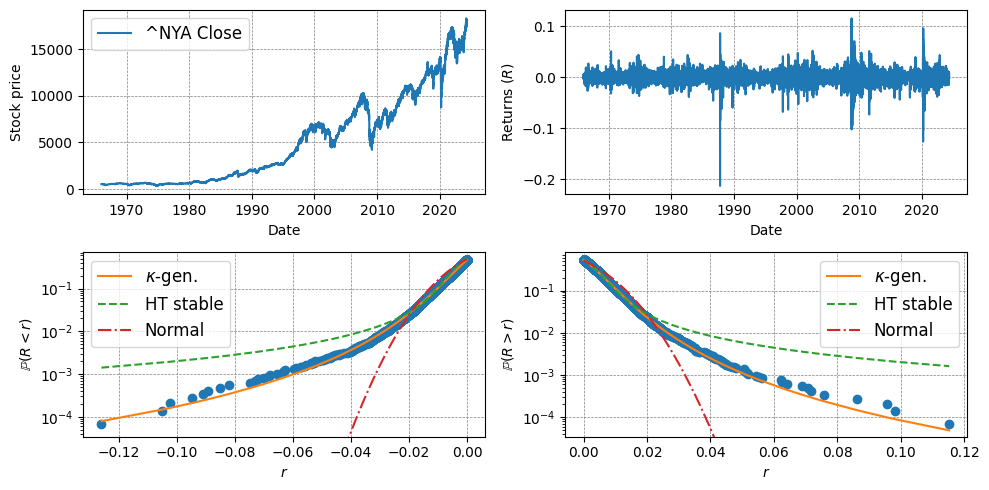

In [6]:
%%time
# Plot for single stock
plot_stock_info(data,stock)
# plt.savefig(f'./plots/{stock}.png', bbox_inches='tight')

https://www.scrapingbee.com/blog/selenium-python/

https://stackoverflow.com/questions/37879010/selenium-debugging-element-is-not-clickable-at-point-x-y

In [7]:
%%time
'''
Get the stock codes for the FTSE 100 from the London stock exchange and use Python's selenium to extract them. 
See: https://www.scrapingbee.com/blog/selenium-python/ for background on selenium.
See: https://stackoverflow.com/questions/37879010/selenium-debugging-element-is-not-clickable-at-point-x-y
to help with clicking through pages error.
'''

URL="https://www.londonstockexchange.com/indices/ftse-100/constituents/table" # URL for London stock exchange to get stock codes
driver = webdriver.Chrome()
driver.get(URL)
time.sleep(2) # Needed so page can load

# Initialise array to store FTSE 100 stock codes
FTSE100_stocks = []
# Keep going through stock pages till get all 100 unique stocks - for some reason may have to go through the pages more than once
while len(FTSE100_stocks)<100:
    for page in driver.find_elements(By.XPATH,'//*[@id="ftse-index-table"]/app-paginator/div/a'): # Xpath to clicker
        driver.execute_script("arguments[0].click();", page)  # Click to another page, use instead of page.click() (didn't work)
        time.sleep(2) # Needed so page can load
        print(f"page number: {page.text}") 
        for i in range(1,21):
            for element in driver.find_elements(By.XPATH, f'//*[@id="ftse-index-table"]/table/tbody/tr[{i}]'): # Xpath to table
                s = element.text
                s1 = s.split()
                if s1[0] not in FTSE100_stocks:
                    FTSE100_stocks.append(s1[0])
    print(len(FTSE100_stocks))
    
driver.quit() # Quit the webpage
###################################################################
FTSE100_stocks.sort() # Sorts the codes alphabetically

# Now get stock codes so they match the yahoo versions (they end with .L and minor adjustment to stock BT.A)
FTSE100_stocks1=[]
for i in range(len(FTSE100_stocks)):
    s=FTSE100_stocks[i]
    if s=='BT.A':
        s='BT-A.L'
    elif s[-1] == '.':
        s=s+'L'
    else:
        s=s+'.L'
    FTSE100_stocks1.append(s)

print('\n',FTSE100_stocks1)

page number: 1
page number: 2
page number: 3
page number: 4
page number: 5
100

 ['AAF.L', 'AAL.L', 'ABF.L', 'ADM.L', 'AHT.L', 'ANTO.L', 'AUTO.L', 'AV.L', 'AZN.L', 'BA.L', 'BARC.L', 'BATS.L', 'BDEV.L', 'BEZ.L', 'BKG.L', 'BME.L', 'BNZL.L', 'BP.L', 'BRBY.L', 'BT-A.L', 'CCH.L', 'CNA.L', 'CPG.L', 'CRDA.L', 'CTEC.L', 'DCC.L', 'DGE.L', 'DPLM.L', 'ENT.L', 'EXPN.L', 'EZJ.L', 'FCIT.L', 'FLTR.L', 'FRAS.L', 'FRES.L', 'GLEN.L', 'GSK.L', 'HIK.L', 'HLMA.L', 'HLN.L', 'HSBA.L', 'HWDN.L', 'IAG.L', 'ICG.L', 'IHG.L', 'III.L', 'IMB.L', 'IMI.L', 'INF.L', 'ITRK.L', 'JD.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'LSEG.L', 'MKS.L', 'MNDI.L', 'MNG.L', 'MRO.L', 'NG.L', 'NWG.L', 'NXT.L', 'OCDO.L', 'PHNX.L', 'PRU.L', 'PSH.L', 'PSN.L', 'PSON.L', 'REL.L', 'RIO.L', 'RKT.L', 'RMV.L', 'RR.L', 'RS1.L', 'RTO.L', 'SBRY.L', 'SDR.L', 'SGE.L', 'SGRO.L', 'SHEL.L', 'SKG.L', 'SMDS.L', 'SMIN.L', 'SMT.L', 'SN.L', 'SPX.L', 'SSE.L', 'STAN.L', 'STJ.L', 'SVT.L', 'TSCO.L', 'TW.L', 'ULVR.L', 'UTG.L', 'UU.L', 'VOD.L', 'WEIR.L', 'WPP.L'

In [8]:
%%time
'''
Get the stock codes for the top 100 Nasdaq stocks using selenium.
'''

URL="https://www.nasdaq.com/market-activity/quotes/nasdaq-ndx-index" # URL for Nasdaq website for top 100 Nasdaq stock codes
driver = webdriver.Chrome()
driver.get(URL)
time.sleep(2) # Needed so page can load

# Initialise array to store Nasdaq top 100 stock codes
Nasdaq100_stocks = []
x_path = '/html/body/div[2]/div/main/div[2]/article/div[2]/div/div[3]/div[3]/div[2]/table/tbody/tr' # Xpath to table
c=0
for element in driver.find_elements(By.XPATH, x_path): # Xpath to table
    if c < 100: # Get first 100 (101 on webpage)
        s = element.text
        s1 = s.split()
        Nasdaq100_stocks.append(s1[0])
        c+=1

print(Nasdaq100_stocks)
print(len(Nasdaq100_stocks))
driver.quit() # Quit the webpage

['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LIN', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'TEAM', 'TMUS', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL']
100
CPU times: user 43.2 ms, sys: 11.6 ms, total: 54.8 ms
Wall time: 4.91 s


In [9]:
%%time
'''
Get the KS error for the normal and k-generalised tail fits to negative and positive log-returns
for FTSE 100 stocks and Nasdaq top 100 stocks. Note some returns are extreme and can give an error when minimising negative
of log-likelihood to fit k-gen.
Takes around 1min 15s.
'''

params_FTSE100, errors_FTSE100_norm, errors_FTSE100_levy_stable, errors_FTSE100_k_gen = tail_fns.tail_params_errors(FTSE100_stocks1)
print('Fin.')
params_Nasdaq100, errors_Nasdaq100_norm, errors_Nasdaq100_levy_stable, errors_Nasdaq100_k_gen  = tail_fns.tail_params_errors(Nasdaq100_stocks)
print('Fin.')

[*********************100%%**********************]  1 of 1 completed


0


[*********************100%%**********************]  1 of 1 completed


1


[*********************100%%**********************]  1 of 1 completed


2


[*********************100%%**********************]  1 of 1 completed


3


[*********************100%%**********************]  1 of 1 completed


4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

5


6


[*********************100%%**********************]  1 of 1 completed


7


[*********************100%%**********************]  1 of 1 completed


8


[*********************100%%**********************]  1 of 1 completed


9


[*********************100%%**********************]  1 of 1 completed


10


[*********************100%%**********************]  1 of 1 completed


11


[*********************100%%**********************]  1 of 1 completed


12


[*********************100%%**********************]  1 of 1 completed


13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

14


15


[*********************100%%**********************]  1 of 1 completed


16


[*********************100%%**********************]  1 of 1 completed


17


[*********************100%%**********************]  1 of 1 completed


18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

19


20


[*********************100%%**********************]  1 of 1 completed


21


[*********************100%%**********************]  1 of 1 completed


22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

23


24


[*********************100%%**********************]  1 of 1 completed


25


[*********************100%%**********************]  1 of 1 completed


26


[*********************100%%**********************]  1 of 1 completed


27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28


29


[*********************100%%**********************]  1 of 1 completed


30


[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


31


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

32



[*********************100%%**********************]  1 of 1 completed

33



[*********************100%%**********************]  1 of 1 completed

34


35


[*********************100%%**********************]  1 of 1 completed


36


[*********************100%%**********************]  1 of 1 completed


37


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

38


39


[*********************100%%**********************]  1 of 1 completed


40


[*********************100%%**********************]  1 of 1 completed


41


[*********************100%%**********************]  1 of 1 completed


42


[*********************100%%**********************]  1 of 1 completed


43


[*********************100%%**********************]  1 of 1 completed


44


[*********************100%%**********************]  1 of 1 completed


45


[*********************100%%**********************]  1 of 1 completed


46


[*********************100%%**********************]  1 of 1 completed


47


[*********************100%%**********************]  1 of 1 completed


48


[*********************100%%**********************]  1 of 1 completed


49


[*********************100%%**********************]  1 of 1 completed


50


[*********************100%%**********************]  1 of 1 completed


51


[*********************100%%**********************]  1 of 1 completed


52


[*********************100%%**********************]  1 of 1 completed


53


[*********************100%%**********************]  1 of 1 completed


54


[*********************100%%**********************]  1 of 1 completed


55


[*********************100%%**********************]  1 of 1 completed


56


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

57


58


[*********************100%%**********************]  1 of 1 completed


59


[*********************100%%**********************]  1 of 1 completed


60


[*********************100%%**********************]  1 of 1 completed


61


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

62


63


[*********************100%%**********************]  1 of 1 completed


64


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

65


66


[*********************100%%**********************]  1 of 1 completed


67


[*********************100%%**********************]  1 of 1 completed


68


[*********************100%%**********************]  1 of 1 completed


69


[*********************100%%**********************]  1 of 1 completed


70


[*********************100%%**********************]  1 of 1 completed


71


[*********************100%%**********************]  1 of 1 completed


72


[*********************100%%**********************]  1 of 1 completed


73


[*********************100%%**********************]  1 of 1 completed


74


[*********************100%%**********************]  1 of 1 completed


75


[*********************100%%**********************]  1 of 1 completed


76


[*********************100%%**********************]  1 of 1 completed


77


[*********************100%%**********************]  1 of 1 completed


78


[*********************100%%**********************]  1 of 1 completed


79


[*********************100%%**********************]  1 of 1 completed


80


[*********************100%%**********************]  1 of 1 completed


81


[*********************100%%**********************]  1 of 1 completed


82


[*********************100%%**********************]  1 of 1 completed


83


[*********************100%%**********************]  1 of 1 completed


84


[*********************100%%**********************]  1 of 1 completed


85


[*********************100%%**********************]  1 of 1 completed


86


[*********************100%%**********************]  1 of 1 completed


87


[*********************100%%**********************]  1 of 1 completed


88


[*********************100%%**********************]  1 of 1 completed


89


[*********************100%%**********************]  1 of 1 completed


90


[*********************100%%**********************]  1 of 1 completed


91


[*********************100%%**********************]  1 of 1 completed


92


[*********************100%%**********************]  1 of 1 completed


93


[*********************100%%**********************]  1 of 1 completed


94


[*********************100%%**********************]  1 of 1 completed


95


[*********************100%%**********************]  1 of 1 completed


96


[*********************100%%**********************]  1 of 1 completed


97


[*********************100%%**********************]  1 of 1 completed


98


[*********************100%%**********************]  1 of 1 completed


99
Fin.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0


1


[*********************100%%**********************]  1 of 1 completed


2


[*********************100%%**********************]  1 of 1 completed


3


[*********************100%%**********************]  1 of 1 completed


4


[*********************100%%**********************]  1 of 1 completed


5


[*********************100%%**********************]  1 of 1 completed


6


[*********************100%%**********************]  1 of 1 completed


7


[*********************100%%**********************]  1 of 1 completed


8


[*********************100%%**********************]  1 of 1 completed


9


[*********************100%%**********************]  1 of 1 completed


10


[*********************100%%**********************]  1 of 1 completed


11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

12


13


[*********************100%%**********************]  1 of 1 completed


14


[*********************100%%**********************]  1 of 1 completed


15


[*********************100%%**********************]  1 of 1 completed


16


[*********************100%%**********************]  1 of 1 completed


17


[*********************100%%**********************]  1 of 1 completed


18


[*********************100%%**********************]  1 of 1 completed


19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

20



[*********************100%%**********************]  1 of 1 completed

21


22


[*********************100%%**********************]  1 of 1 completed


23


[*********************100%%**********************]  1 of 1 completed


24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

25


26


[*********************100%%**********************]  1 of 1 completed


27


[*********************100%%**********************]  1 of 1 completed


28


[*********************100%%**********************]  1 of 1 completed


29


[*********************100%%**********************]  1 of 1 completed


30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

31



[*********************100%%**********************]  1 of 1 completed

32


33


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

34


35


[*********************100%%**********************]  1 of 1 completed


36


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

37


38


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

39



[*********************100%%**********************]  1 of 1 completed

40



[*********************100%%**********************]  1 of 1 completed

41


42


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

43



[*********************100%%**********************]  1 of 1 completed

44


45


[*********************100%%**********************]  1 of 1 completed


46


[*********************100%%**********************]  1 of 1 completed


47


[*********************100%%**********************]  1 of 1 completed


48


[*********************100%%**********************]  1 of 1 completed


49


[*********************100%%**********************]  1 of 1 completed


50


[*********************100%%**********************]  1 of 1 completed


51


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

52


53


[*********************100%%**********************]  1 of 1 completed


54


[*********************100%%**********************]  1 of 1 completed


55


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

56


57


[*********************100%%**********************]  1 of 1 completed


58


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

59


60


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

61



[*********************100%%**********************]  1 of 1 completed

62


63


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

64


65


[*********************100%%**********************]  1 of 1 completed


66


[*********************100%%**********************]  1 of 1 completed


67


[*********************100%%**********************]  1 of 1 completed


68


[*********************100%%**********************]  1 of 1 completed


69


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

70


71


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

72


73


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

74


75


[*********************100%%**********************]  1 of 1 completed


76


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

77


78


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

79


80


[*********************100%%**********************]  1 of 1 completed


81


[*********************100%%**********************]  1 of 1 completed


82


[*********************100%%**********************]  1 of 1 completed


83


[*********************100%%**********************]  1 of 1 completed


84


[*********************100%%**********************]  1 of 1 completed


85


[*********************100%%**********************]  1 of 1 completed


86


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

87



[*********************100%%**********************]  1 of 1 completed

88



[*********************100%%**********************]  1 of 1 completed

89



[*********************100%%**********************]  1 of 1 completed

90


91


[*********************100%%**********************]  1 of 1 completed


92


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

93


94


[*********************100%%**********************]  1 of 1 completed


95


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

96



[*********************100%%**********************]  1 of 1 completed

97


98


[*********************100%%**********************]  1 of 1 completed


99
Fin.
CPU times: user 13min 17s, sys: 10.2 s, total: 13min 28s
Wall time: 14min 8s


In [10]:
params_FTSE100 = np.array(params_FTSE100,dtype=object)
params_Nasdaq100 = np.array(params_Nasdaq100,dtype=object)

In [11]:
# Print how many times error of normal fit worse than Levy-stable
print(tail_fns.where_greater(errors_FTSE100_norm, errors_FTSE100_levy_stable))
print(tail_fns.where_greater(errors_Nasdaq100_norm, errors_Nasdaq100_levy_stable))
print(' ')
# Print how many times error of normal fit worse than k-gen fit
print(tail_fns.where_greater(errors_FTSE100_norm, errors_FTSE100_k_gen))
print(tail_fns.where_greater(errors_Nasdaq100_norm, errors_Nasdaq100_k_gen))
print(' ')
# Print how many times error of Levy-stable fit worse than k-gen fit
print(tail_fns.where_greater(errors_FTSE100_levy_stable, errors_FTSE100_k_gen))
print(tail_fns.where_greater(errors_Nasdaq100_levy_stable, errors_Nasdaq100_k_gen))

90
97
 
100
100
 
100
100


In [12]:
# Characteristics (min, max, mean, variance) for the normal, Levy-stable  and k-gen errors to FTSE 100 stocks

print('FTSE 100 root mean square errors (min, max, mean, variance) for normal, Levy-stable and k-gen:')
print(tail_fns.get_characteristics_errors(errors_FTSE100_norm))
print(tail_fns.get_characteristics_errors(errors_FTSE100_levy_stable))
print(tail_fns.get_characteristics_errors(errors_FTSE100_k_gen))
print('\n Nasdaq top 100 root mean square errors (min, max, mean, variance) for normal, Levy-stable and k-gen:')
print(tail_fns.get_characteristics_errors(errors_Nasdaq100_norm))
print(tail_fns.get_characteristics_errors(errors_Nasdaq100_levy_stable))
print(tail_fns.get_characteristics_errors(errors_Nasdaq100_k_gen))

FTSE 100 root mean square errors (min, max, mean, variance) for normal, Levy-stable and k-gen:
(0.055818479146386574, 0.3841793130257759, 0.10943312589995514, 0.0028383603327890496)
(0.013056139296843128, 0.3534592914086392, 0.07043120537170224, 0.003250800301233977)
(0.005439878028727196, 0.02255077186323129, 0.010579915678560148, 1.3789877599186044e-05)

 Nasdaq top 100 root mean square errors (min, max, mean, variance) for normal, Levy-stable and k-gen:
(0.034597657093791284, 0.22394521250587957, 0.09607959498984181, 0.0006049399398806722)
(0.013769844657091301, 0.14711761481866048, 0.050135057460989, 0.0006735044936647429)
(0.004212917943305916, 0.020936431276096706, 0.009094850670629621, 1.1554088481691952e-05)


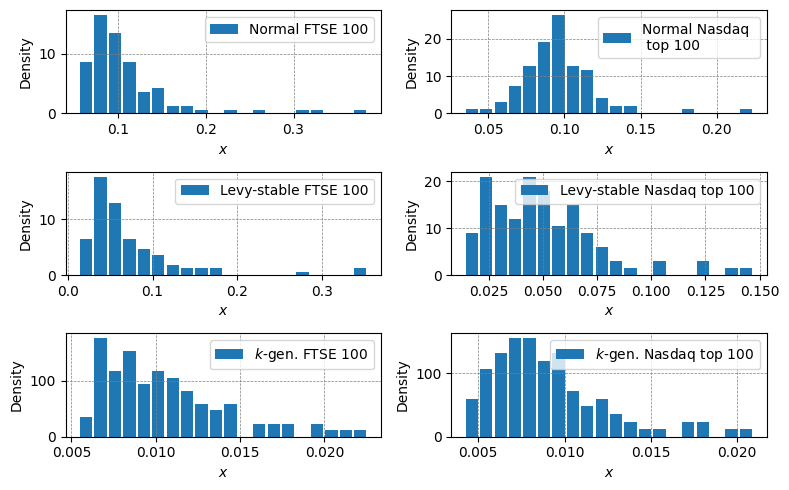

In [13]:
# Histogram of normal, Levy-stable and k-gen KS error fits to FTSE 100 and Nasdaq top 100.

fig, ax = plt.subplots(3, 2, figsize=(8,5))

n_bins = 20
font_sizes = [10,10,10,10,10]
leg = 1
labels=[r'$x$','Density',font_sizes,leg]

ax[0,0].hist(errors_FTSE100_norm, bins=n_bins, rwidth=0.85, density = True, label = 'Normal FTSE 100')
plotting(ax[0,0],*labels).add_labels()

ax[0,1].hist(errors_Nasdaq100_norm, bins=n_bins, rwidth=0.85, density = True, label = 'Normal Nasdaq \n top 100')
plotting(ax[0,1],*labels).add_labels()

ax[1,0].hist(errors_FTSE100_levy_stable, bins=n_bins, rwidth=0.85, density = True, label = 'Levy-stable FTSE 100')
plotting(ax[1,0],*labels).add_labels()

ax[1,1].hist(errors_Nasdaq100_levy_stable, bins=n_bins, rwidth=0.85, density = True, label = 'Levy-stable Nasdaq top 100')
plotting(ax[1,1],*labels).add_labels()

ax[2,0].hist(errors_FTSE100_k_gen, bins=n_bins, rwidth=0.85, density = True, label = r'$k$-gen. FTSE 100')
plotting(ax[2,0],*labels).add_labels()

ax[2,1].hist(errors_Nasdaq100_k_gen, bins=n_bins, rwidth=0.85, density = True, label = r'$k$-gen. Nasdaq top 100')
plotting(ax[2,1],*labels).add_labels()

plt.tight_layout()

In [14]:
%%time

'''
Plots of all FTSE 100 stocks.
Takes around .
'''

for i in range(len(FTSE100_stocks1)):
    stock = FTSE100_stocks1[i]
    print(stock)
    data = yf.download(stock, period="max")
    print(tail_error(data))
    plot_stock_info(data,stock)

[*********************100%%**********************]  1 of 1 completed

AAF.L


NameError: name 'tail_error' is not defined

In [15]:
%%time

'''
Plots of all Nasdaq top 100 stocks.
Nasdaq top 100 stocks with fitting/other issues:
Takes around  .
'''

for i in range(len(Nasdaq100_stocks)):
    stock = Nasdaq100_stocks[i]
    print(stock)
    data = yf.download(stock, period="max")
    print(tail_error(data))
    plot_stock_info(data,stock)

AAPL


[*********************100%%**********************]  1 of 1 completed


NameError: name 'tail_error' is not defined

https://stats.stackexchange.com/questions/126539/testing-whether-data-follows-t-distribution/126552#126552

https://stats.stackexchange.com/questions/45033/can-i-use-kolmogorov-smirnov-test-and-estimate-distribution-parameters

In [16]:
%%time
'''
Get estimated p-values of k-generalised fit to FTSE 100 and Nasdaq top 100 stocks.
Takes around 25 mins.
'''
p_values_FTSE100, p_values_Nasdaq100 = [], [] # Initialise arrays to store FTSE 100 and Nasdaq top 100 stock name with corresponding p-values
N=100 # Number of simulations to generate estimated p-value
for i in range(100):
    stock = FTSE100_stocks1[i]
    stock1 = Nasdaq100_stocks[i]
    data = yf.download(stock, period="max")
    data1 = yf.download(stock1, period="max")
    p_value_neg, p_value_pos = p_values_k_gen_fits(N,data) # p-values FTSE 100
    p_value_neg1, p_value_pos1 = p_values_k_gen_fits(N,data1) # p-values Nasdaq top 100
    print(p_value_neg, p_value_pos)
    print(p_value_neg1, p_value_pos1)
    p_values_FTSE100.append([stock, p_value_neg, p_value_pos])
    p_values_Nasdaq100.append([stock1, p_value_neg1, p_value_pos1])
    print(i)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.66 0.75
0.01 0.06
0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.45 0.2
0.71 0.69
1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.01 0.03
2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.17
0.14 0.0
3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.0 0.0
4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.0 0.0
0.43 0.03
5



[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.19 0.03
0.0 0.0
6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))


0.0 0.0
0.04 0.04
7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.27 0.36
0.0 0.01
8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.02 0.14
9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.1 0.01
0.17 0.2
10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.3
0.81 0.43
11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.0
0.02 0.73
12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.32 0.18
13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.0 0.0
0.13 0.59
14



[*********************100%%**********************]  1 of 1 completed


0.11 0.85
0.19 0.03
15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.03 0.09
0.04 0.21
16


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.04 0.21
0.01 0.57
17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.12 0.17
0.0 0.0
18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.01 0.12
0.03 0.0
19



[*********************100%%**********************]  1 of 1 completed


0.0 0.15
0.82 0.26
20


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.04 0.64
0.72 0.94
21


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.06
0.34 0.49
22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.0 0.0
0.0 0.0
23



[*********************100%%**********************]  1 of 1 completed


0.12 0.29
0.0 0.0
24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:195: RuntimeWarning: overflow encountered in power
  s1=a*b*x**(a-1)
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:196: RuntimeWarning: overflow encountered in power
  s2=np.sqrt(1+b**2*k**2*x**(2*a))
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:104: RuntimeWarning: overflow encountered in power
  x1= -b*x**a
/var/folders/pv/jsktch8x

0.12 0.16
0.3 0.15
25


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.03
0.04 0.88
26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.0 0.12
27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:97: RuntimeWarning: invalid value encountered in power
  return (np.sqrt(1+k**2*x**2)+k*x)**(1/k)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
[*********************100%%**********************]  1 of 1 completed

0.03 0.06
0.31 0.99
28



[*********************100%%**********************]  1 of 1 completed


0.13 0.25
0.0 0.0
29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.13 0.09
0.01 0.04
30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.02 0.0
0.7 0.59
31


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.58 0.4
0.08 0.44
32



[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:97: RuntimeWarning: invalid value encountered in power
  return (np.sqrt(1+k**2*x**2)+k*x)**(1/k)
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:196: RuntimeWarning: overflow encountered in power
  s2=np.sqrt(1+b**2*k**2*x**(2*a))
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:97: RuntimeWarning: overflow encountered in square
  return (np.sqrt(1+k**2*x**2)+k*x)**(1/k)
/var/folders/pv/jsktch8x0vdg6f2rb7

0.08 0.19
0.62 0.52
33


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.55 0.56
0.54 0.51
34



[*********************100%%**********************]  1 of 1 completed


0.42 0.9
0.02 0.82
35


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.03 0.11
0.09 0.01
36


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.07 0.31
0.0 0.0
37


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.0 0.0
0.33 0.38
38



[*********************100%%**********************]  1 of 1 completed


0.71 0.52
0.66 0.5
39


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.06
0.16 0.17
40


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.4 0.66
41


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.11 0.81
0.92 0.88
42


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.22 0.02
43


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.29
0.71 0.04
44


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.8 0.32
45


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.05 0.16
0.0 0.0
46


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.22 0.08
47


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.05 0.0
0.83 0.74
48


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.75
0.0 0.0
49


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.0
0.02 0.3
50


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.01
0.39 0.96
51


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.17 0.28
52


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.72 0.98
53


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.26 0.08
0.0 0.0
54


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.34 0.02
0.58 0.8
55


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.0 0.0
0.04 0.01
56



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.54 0.41
0.53 0.83
57



[*********************100%%**********************]  1 of 1 completed


0.23 0.72
0.07 0.59
58


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.41 0.09
59


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.14 0.6
60


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.22 0.62
61


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.36
0.43 0.35
62


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.54 0.6
0.19 0.0
63



[*********************100%%**********************]  1 of 1 completed


0.09 0.56
0.0 0.0
64


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.03 0.02
0.66 0.68
65



[*********************100%%**********************]  1 of 1 completed


0.0 0.05
0.65 0.35
66


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.01 0.79
67


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.01
0.0 0.02
68


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.5 0.18
69


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.1
0.6 0.53
70


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.01
0.01 0.08
71


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.03 0.8
0.03 0.09
72


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.0 0.36
73


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.35 0.38
74


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.94 0.33
75


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.07 0.0
0.48 0.0
76


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.0 0.0
77


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.75 0.2
78


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.0 0.0
79


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.15 0.49
0.51 0.89
80


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.28 0.46
0.01 0.63
81


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.02 0.0
82


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.48 0.11
83


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0 0.0
0.23 0.11
84


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.12 0.0
85


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:97: RuntimeWarning: invalid value encountered in power
  return (np.sqrt(1+k**2*x**2)+k*x)**(1/k)


0.0 0.0
0.0 0.0
86


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.02 0.01
87


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.0
0.59 0.64
88


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.13 0.0
0.09 0.34
89


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.61 0.01
90


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.19 0.01
0.19 0.29
91


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.02 0.6
92


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.02 0.05
0.0 0.0
93


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.06 0.07
94


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.02
0.24 0.37
95


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.01
0.0 0.0
96


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.0 0.0
0.23 0.4
97


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.01 0.01
0.71 0.14
98


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/pv/jsktch8x0vdg6f2rb7pcpzd40000gn/T/ipykernel_27783/2980152425.py:205: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(k_gen_fitting.k_gen_dens(x,*params)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.01 0.0
0.0 0.0
99
CPU times: user 22min 55s, sys: 1min 23s, total: 24min 19s
Wall time: 25min 4s


0.66 0.75
0.01 0.06
0

0.43 0.2
0.71 0.63
1

0.0 0.0
0.01 0.03
2

0.0 0.17
0.14 0.0
3

0.0 0.0
0.0 0.0
4

0.0 0.0
0.42 0.03
5

0.19 0.04
0.0 0.0
6

In [17]:
'''
Put p-values into data frame
'''
column_names = ['Stock', 'Neg. log-return p-value', 'Pos. log-return p-value'] # Column names
p_values_FTSE100d = pd.DataFrame(p_values_FTSE100, columns = column_names)
p_values_Nasdaq100d = pd.DataFrame(p_values_Nasdaq100, columns = column_names)

In [18]:
'''
Number of significant p-values (> alpha = 0.1)
'''
alpha = 0.1
ind_p_values_FTSE100_neg = np.where(p_values_FTSE100d['Neg. log-return p-value']>alpha)[0]
ind_p_values_FTSE100_pos = np.where(p_values_FTSE100d['Pos. log-return p-value']>alpha)[0]
ind_p_values_FTSE100_both = list(set(ind_p_values_FTSE100_neg) & set(ind_p_values_FTSE100_pos))
ind_p_values_FTSE100_either = list(set(np.concatenate((ind_p_values_FTSE100_neg,ind_p_values_FTSE100_pos))))

ind_p_values_Nasdaq100_neg = np.where(p_values_Nasdaq100d['Neg. log-return p-value']>alpha)[0]
ind_p_values_Nasdaq100_pos = np.where(p_values_Nasdaq100d['Pos. log-return p-value']>alpha)[0]
ind_p_values_Nasdaq100_both = list(set(ind_p_values_Nasdaq100_neg) & set(ind_p_values_Nasdaq100_pos))
ind_p_values_Nasdaq100_either = list(set(np.concatenate((ind_p_values_Nasdaq100_neg,ind_p_values_Nasdaq100_pos))))

print('No. of significant FTSE 100 stocks negative tail: ')
print(len(ind_p_values_FTSE100_neg))
print('\n No. of significant FTSE 100 stocks positive tail: ')
print(len(ind_p_values_FTSE100_pos))
print('\n No. of significant FTSE 100 stocks both tails: ')
print(len(ind_p_values_FTSE100_both))
print('\n No. of significant FTSE 100 stocks either tail: ')
print(len(ind_p_values_FTSE100_either))

print('\n No. of significant Nasdaq top 100 stocks negative tail: ')
print(len(ind_p_values_Nasdaq100_neg))
print('\n No. of significant Nasdaq top 100 stocks positive tail: ')
print(len(ind_p_values_Nasdaq100_pos))
print('\n No. of significant Nasdaq top 100 stocks both tails: ')
print(len(ind_p_values_Nasdaq100_both))
print('\n No. of significant Nasdaq top 100 stocks either tail: ')
print(len(ind_p_values_Nasdaq100_either))

No. of significant FTSE 100 stocks negative tail: 
24

 No. of significant FTSE 100 stocks positive tail: 
33

 No. of significant FTSE 100 stocks both tails: 
18

 No. of significant FTSE 100 stocks either tail: 
39

 No. of significant Nasdaq top 100 stocks negative tail: 
54

 No. of significant Nasdaq top 100 stocks positive tail: 
58

 No. of significant Nasdaq top 100 stocks both tails: 
43

 No. of significant Nasdaq top 100 stocks either tail: 
69


No. of significant FTSE 100 stocks negative tail: 
24

 No. of significant FTSE 100 stocks positive tail: 
33

 No. of significant FTSE 100 stocks both tails: 
18

 No. of significant FTSE 100 stocks either tail: 
39

 No. of significant Nasdaq top 100 stocks negative tail: 
54

 No. of significant Nasdaq top 100 stocks positive tail: 
58

 No. of significant Nasdaq top 100 stocks both tails: 
43

 No. of significant Nasdaq top 100 stocks either tail: 
69


In [19]:
#Get stock codes into an array
FTSE100_stocks=np.asarray(FTSE100_stocks)
FTSE100_stocks1=np.asarray(FTSE100_stocks1)
Nasdaq100_stocks=np.asarray(Nasdaq100_stocks)

In [20]:
# Print stock codes that are significantly fitted by k-gen. for negative and positive tail
print('Significant FTSE 100 stocks negative tail:')
print(FTSE100_stocks[ind_p_values_FTSE100_neg])
print('\n Significant FTSE 100 stocks positive tail:')
print(FTSE100_stocks[ind_p_values_FTSE100_pos])
print('\n Significant FTSE 100 stocks both tails:')
print(FTSE100_stocks[ind_p_values_FTSE100_both])
print('\n Significant FTSE 100 stocks either tail:')
print(FTSE100_stocks[ind_p_values_FTSE100_either])

print('\n Significant Nasdaq top 100 stocks negative tail: ')
print(Nasdaq100_stocks[ind_p_values_Nasdaq100_neg])
print('\n Significant Nasdaq top 100 stocks positive tail:')
print(Nasdaq100_stocks[ind_p_values_Nasdaq100_pos])
print('\n Significant Nasdaq top 100 stocks both tails:')
print(Nasdaq100_stocks[ind_p_values_Nasdaq100_both])
print('\n Significant Nasdaq top 100 stocks either tail:')
print(Nasdaq100_stocks[ind_p_values_Nasdaq100_either])

Significant FTSE 100 stocks negative tail:
['AAF' 'AAL' 'AUTO' 'AZN' 'BME' 'BRBY' 'CTEC' 'DCC' 'EXPN' 'EZJ' 'FLTR'
 'FRES' 'GLEN' 'HLN' 'IAG' 'LLOY' 'LSEG' 'MNDI' 'MNG' 'OCDO' 'SHEL' 'SKG'
 'STJ' 'TSCO']

 Significant FTSE 100 stocks positive tail:
['AAF' 'AAL' 'ADM' 'AZN' 'BATS' 'BME' 'BP.' 'BRBY' 'BT.A' 'CCH' 'CNA'
 'CTEC' 'DCC' 'EXPN' 'FLTR' 'FRAS' 'FRES' 'GLEN' 'GSK' 'HIK' 'HLN' 'IAG'
 'IHG' 'IMB' 'ITRK' 'MNDI' 'MNG' 'NXT' 'OCDO' 'PHNX' 'RMV' 'SHEL' 'SKG']

 Significant FTSE 100 stocks both tails:
['AAF' 'AAL' 'FLTR' 'FRES' 'GLEN' 'HLN' 'AZN' 'IAG' 'BME' 'SHEL' 'SKG'
 'BRBY' 'OCDO' 'CTEC' 'DCC' 'MNG' 'EXPN' 'MNDI']

 Significant FTSE 100 stocks either tail:
['AAF' 'AAL' 'ADM' 'AUTO' 'AZN' 'BATS' 'BME' 'BP.' 'BRBY' 'BT.A' 'CCH'
 'CNA' 'CTEC' 'DCC' 'EXPN' 'EZJ' 'FLTR' 'FRAS' 'FRES' 'GLEN' 'GSK' 'HIK'
 'HLN' 'IAG' 'IHG' 'IMB' 'ITRK' 'LLOY' 'LSEG' 'MNDI' 'MNG' 'NXT' 'OCDO'
 'PHNX' 'RMV' 'SHEL' 'SKG' 'STJ' 'TSCO']

 Significant Nasdaq top 100 stocks negative tail: 
['ABNB' 'ADI' 'ADSK' 

In [21]:
# Find the power law exponents for the heavy-tailed stable and k-gen. fits
FTSE100_ht_stable_alphas = []
FTSE100_k_gen_nt_pl_exps = []
FTSE100_k_gen_pt_pl_exps = []

Nasdaq100_ht_stable_alphas = []
Nasdaq100_k_gen_nt_pl_exps = []
Nasdaq100_k_gen_pt_pl_exps = []

for i in range(len(ind_p_values_FTSE100_both)):
    ht_stable_alpha = params_FTSE100[ind_p_values_FTSE100_both][i][1][0]
    k_gen_nt_pl_exp = params_FTSE100[ind_p_values_FTSE100_both][i][2][1]/params_FTSE100[ind_p_values_FTSE100_both][i][2][0]
    k_gen_pt_pl_exp = params_FTSE100[ind_p_values_FTSE100_both][i][3][1]/params_FTSE100[ind_p_values_FTSE100_both][i][3][0]
    FTSE100_ht_stable_alphas.append(ht_stable_alpha)
    FTSE100_k_gen_nt_pl_exps.append(k_gen_nt_pl_exp)
    FTSE100_k_gen_pt_pl_exps.append(k_gen_pt_pl_exp)

for i in range(len(ind_p_values_Nasdaq100_both)):
    ht_stable_alpha = params_Nasdaq100[ind_p_values_Nasdaq100_both][i][1][0]
    k_gen_nt_pl_exp = params_Nasdaq100[ind_p_values_Nasdaq100_both][i][2][1]/params_Nasdaq100[ind_p_values_Nasdaq100_both][i][2][0]
    k_gen_pt_pl_exp = params_Nasdaq100[ind_p_values_Nasdaq100_both][i][3][1]/params_Nasdaq100[ind_p_values_Nasdaq100_both][i][3][0]
    Nasdaq100_ht_stable_alphas.append(ht_stable_alpha)
    Nasdaq100_k_gen_nt_pl_exps.append(k_gen_nt_pl_exp)
    Nasdaq100_k_gen_pt_pl_exps.append(k_gen_pt_pl_exp)

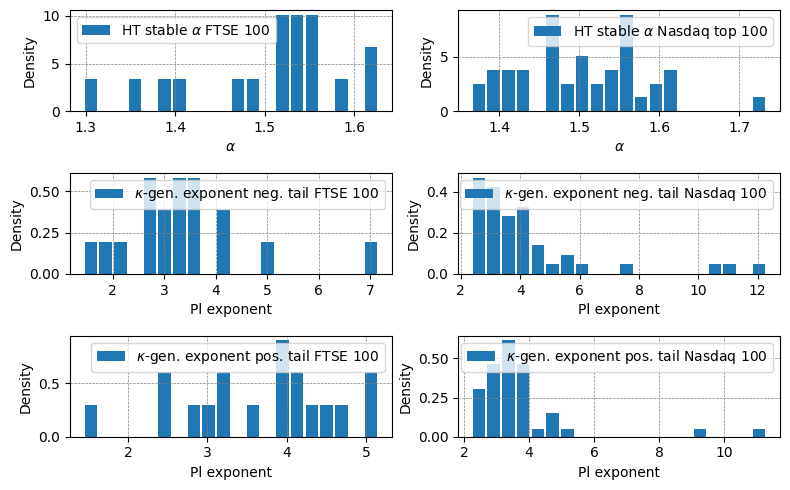

In [22]:
# Plot a histogram for the power law exponents for the heavy-tailed stable and k-gen. fits
fig, ax = plt.subplots(3, 2, figsize=(8,5))

n_bins = 20
font_sizes = [10,10,10,10,10]
leg = 1
labels=[r'$\alpha$','Density',font_sizes,leg]
labels1=['Pl exponent','Density',font_sizes,leg]

ax[0,0].hist(FTSE100_ht_stable_alphas, bins=n_bins, rwidth=0.85, density = True, label = r'HT stable $\alpha$ FTSE 100')
plotting(ax[0,0],*labels).add_labels()

ax[0,1].hist(Nasdaq100_ht_stable_alphas, bins=n_bins, rwidth=0.85, density = True, label = r'HT stable $\alpha$ Nasdaq top 100')
plotting(ax[0,1],*labels).add_labels()

ax[1,0].hist(FTSE100_k_gen_nt_pl_exps, bins=n_bins, rwidth=0.85, density = True, label = r'$\kappa$-gen. exponent neg. tail FTSE 100')
plotting(ax[1,0],*labels1).add_labels()

ax[1,1].hist(Nasdaq100_k_gen_nt_pl_exps, bins=n_bins, rwidth=0.85, density = True, label = r'$\kappa$-gen. exponent neg. tail Nasdaq 100')
plotting(ax[1,1],*labels1).add_labels()

ax[2,0].hist(FTSE100_k_gen_pt_pl_exps, bins=n_bins, rwidth=0.85, density = True, label = r'$\kappa$-gen. exponent pos. tail FTSE 100')
plotting(ax[2,0],*labels1).add_labels()

ax[2,1].hist(Nasdaq100_k_gen_pt_pl_exps, bins=n_bins, rwidth=0.85, density = True, label = r'$\kappa$-gen. exponent pos. tail Nasdaq 100')
plotting(ax[2,1],*labels1).add_labels()

plt.tight_layout()

In [23]:
# Test stocks that are significant in both tails from FTSE 100 and Nasdaq top 100
i1 = 0
i2 = 1
stock1 = FTSE100_stocks1[ind_p_values_FTSE100_both][i1]
stock2 = Nasdaq100_stocks[ind_p_values_Nasdaq100_both][i2]
print(stock1, stock2)
data1 = yf.download(stock1, period="max")
data2 = yf.download(stock2, period="max")

currency1 = yf.Ticker(stock1).info['currency']
currency2 = yf.Ticker(stock2).info['currency']
print(currency1, currency2)

[*********************100%%**********************]  1 of 1 completed

AAF.L AMZN



[*********************100%%**********************]  1 of 1 completed


GBp USD


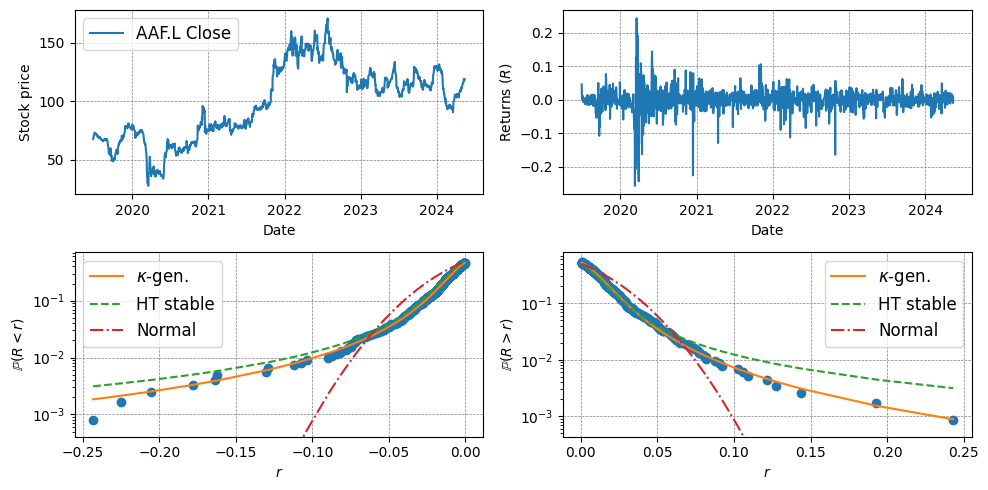

In [24]:
# Plot tails for FTSE
plot_stock_info(data1,stock1)
# plt.savefig(f'./plots/{stock1}.png', bbox_inches='tight')

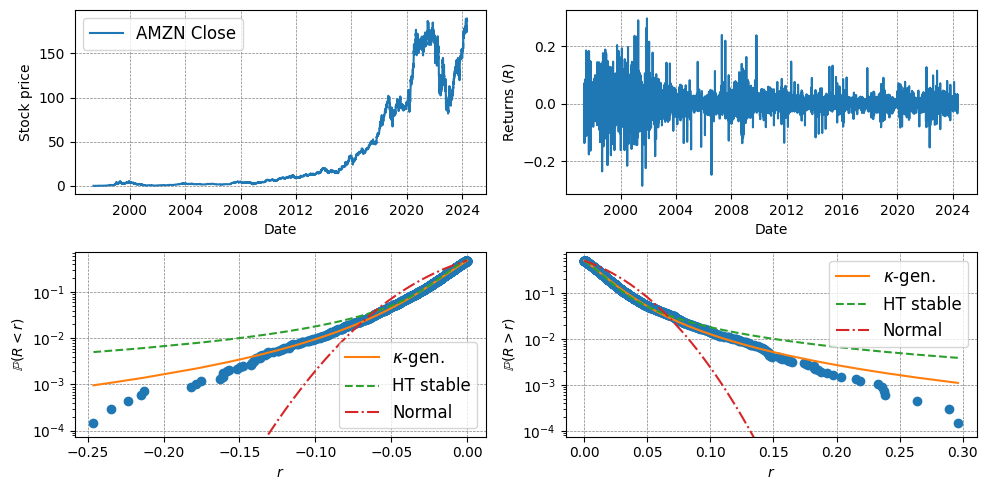

In [28]:
# Plot tails for Nasdaq
plot_stock_info(data2,stock2)
# plt.savefig(f'./plots/{stock2}.png', bbox_inches='tight')

In [26]:
# Get dates and stock prices
dates1, difference_in_years1, stock_prices1 = get_stock_prices_dates(data1)
dates2, difference_in_years2, stock_prices2 = get_stock_prices_dates(data2)

CPU times: user 2.63 s, sys: 20.3 ms, total: 2.65 s
Wall time: 2.67 s


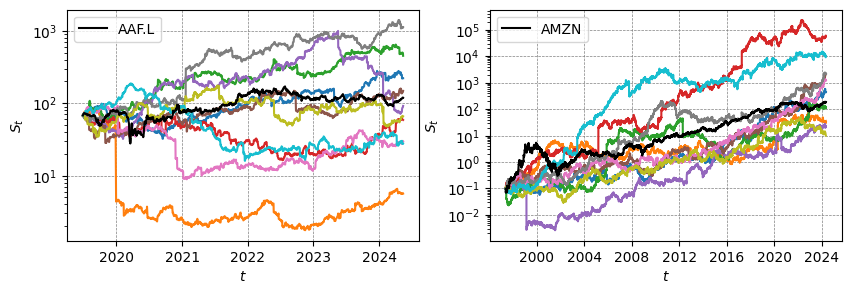

In [27]:
%%time
# Generate stock prices for the above two stocks
fig, ax = plt.subplots(1, 2, figsize=(10,3))

font_sizes = [10,10,10,10,10]

for i in range(10):
    stock_gen1 = generate_stock_values(data1)
    stock_gen2 = generate_stock_values(data2)
    ax[0].plot(dates1,stock_gen1)
    ax[1].plot(dates2,stock_gen2)

ax[0].plot(dates1,stock_prices1,color='black',label=stock1)
leg=1
labels=[r'$t$',r'$S_t$',font_sizes,leg]
plotting(ax[0],*labels).add_labels()
ax[0].set_yscale('log')

ax[1].plot(dates2,stock_prices2,color='black',label=stock2)
leg=1
labels=[r'$t$',r'$S_t$',font_sizes,leg]
plotting(ax[1],*labels).add_labels()
ax[1].set_yscale('log')